# Árboles de Decisión

Vamos a boludear un poco con árboles de decisión

Construyamos un dataset fácil para un concepto relativamente sencillo: que reconozca el cuadrado $[0.5, 1] \times [0.5, 1]$

In [18]:
%pylab inline
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score

# Vamos a hacer un concepto simple:
# (X, Y) es 1 si X, Y están en el cuadrado (0.5, 1)

X = np.random.uniform(0, 1, 1000)
Y = np.random.uniform(0, 1, 1000)

df = pd.DataFrame({'X': X, 'Y': Y})

df['spam'] = df.apply(lambda row: row['X'] > 0.5 and row['Y'] > 0.5, axis=1)

df.iloc[0:10]

Populating the interactive namespace from numpy and matplotlib


/home/marat/.pyenv/versions/2.7.11/envs/aprendizaje/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy', 'clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


,X,Y,spam
0,0.656646,0.025579,False
1,0.011445,0.511361,False
2,0.401556,0.609056,False
3,0.439754,0.448708,False
4,0.409125,0.048338,False
5,0.930041,0.786070,True
6,0.336062,0.044793,False
7,0.995910,0.202969,False
8,0.438244,0.136355,False
9,0.104967,0.519846,False


Grafiquemos el conjunto

Obs: Esto lo copié de la página de pandas http://pandas.pydata.org/pandas-docs/stable/visualization.html

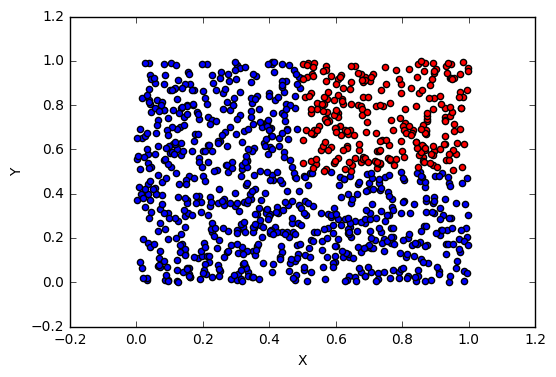

In [19]:
def plot_dataset(df):
    ax = df[df.spam == False].plot.scatter(x='X', y='Y', color='Blue')

    df[df.spam == True].plot.scatter(x='X', y='Y', color='red', ax=ax)

plot_dataset(df)

In [20]:


data = df[['X', 'Y']].values

gini_clf = DecisionTreeClassifier(criterion="gini")
entropy_clf = DecisionTreeClassifier(criterion="entropy")

gini_tree = gini_clf.fit(data, df['spam'])
entropy_tree = entropy_clf.fit(data, df['spam'])

# Grafiquemos el árbol


Esto sacado de https://github.com/scikit-learn/scikit-learn/issues/6261

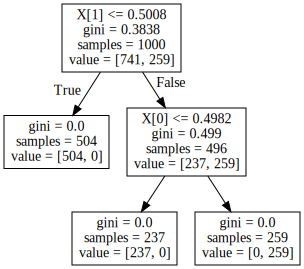

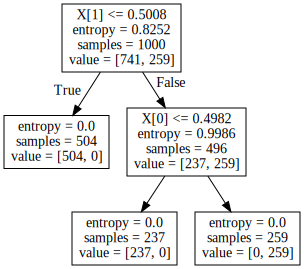

In [21]:
from sklearn.tree import export_graphviz
from IPython.display import display
import tempfile
import graphviz


def create_dotgraph(tree):
    tmpfile = tempfile.NamedTemporaryFile(mode='r+')  
    export_graphviz(tree, out_file=tmpfile.name)
    
    with open(tmpfile.name) as f:
        contents = f.read()
        display(graphviz.Source(contents))


# Por alguna razón no puedo meter esto en la función 
create_dotgraph(gini_tree)
create_dotgraph(entropy_tree)
    


# Ejemplo más complejo

Intentemos reconocer una esfera bidimensional

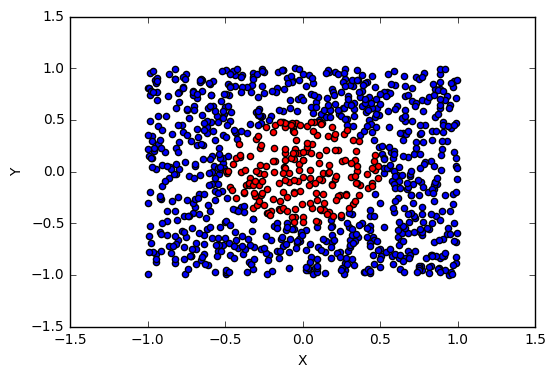

In [22]:
X = np.random.uniform(-1, 1, 1000)
Y = np.random.uniform(-1, 1, 1000)

df = pd.DataFrame({'X': X, 'Y': Y})


df['spam'] = df.apply(lambda row: np.linalg.norm(row) < 0.5, axis=1)

plot_dataset(df)

In [23]:

data = df[['X', 'Y']].values

gini_clf = DecisionTreeClassifier(criterion="gini")
entropy_clf = DecisionTreeClassifier(criterion="entropy")

gini_tree = gini_clf.fit(data, df['spam'])
entropy_tree = entropy_clf.fit(data, df['spam'])

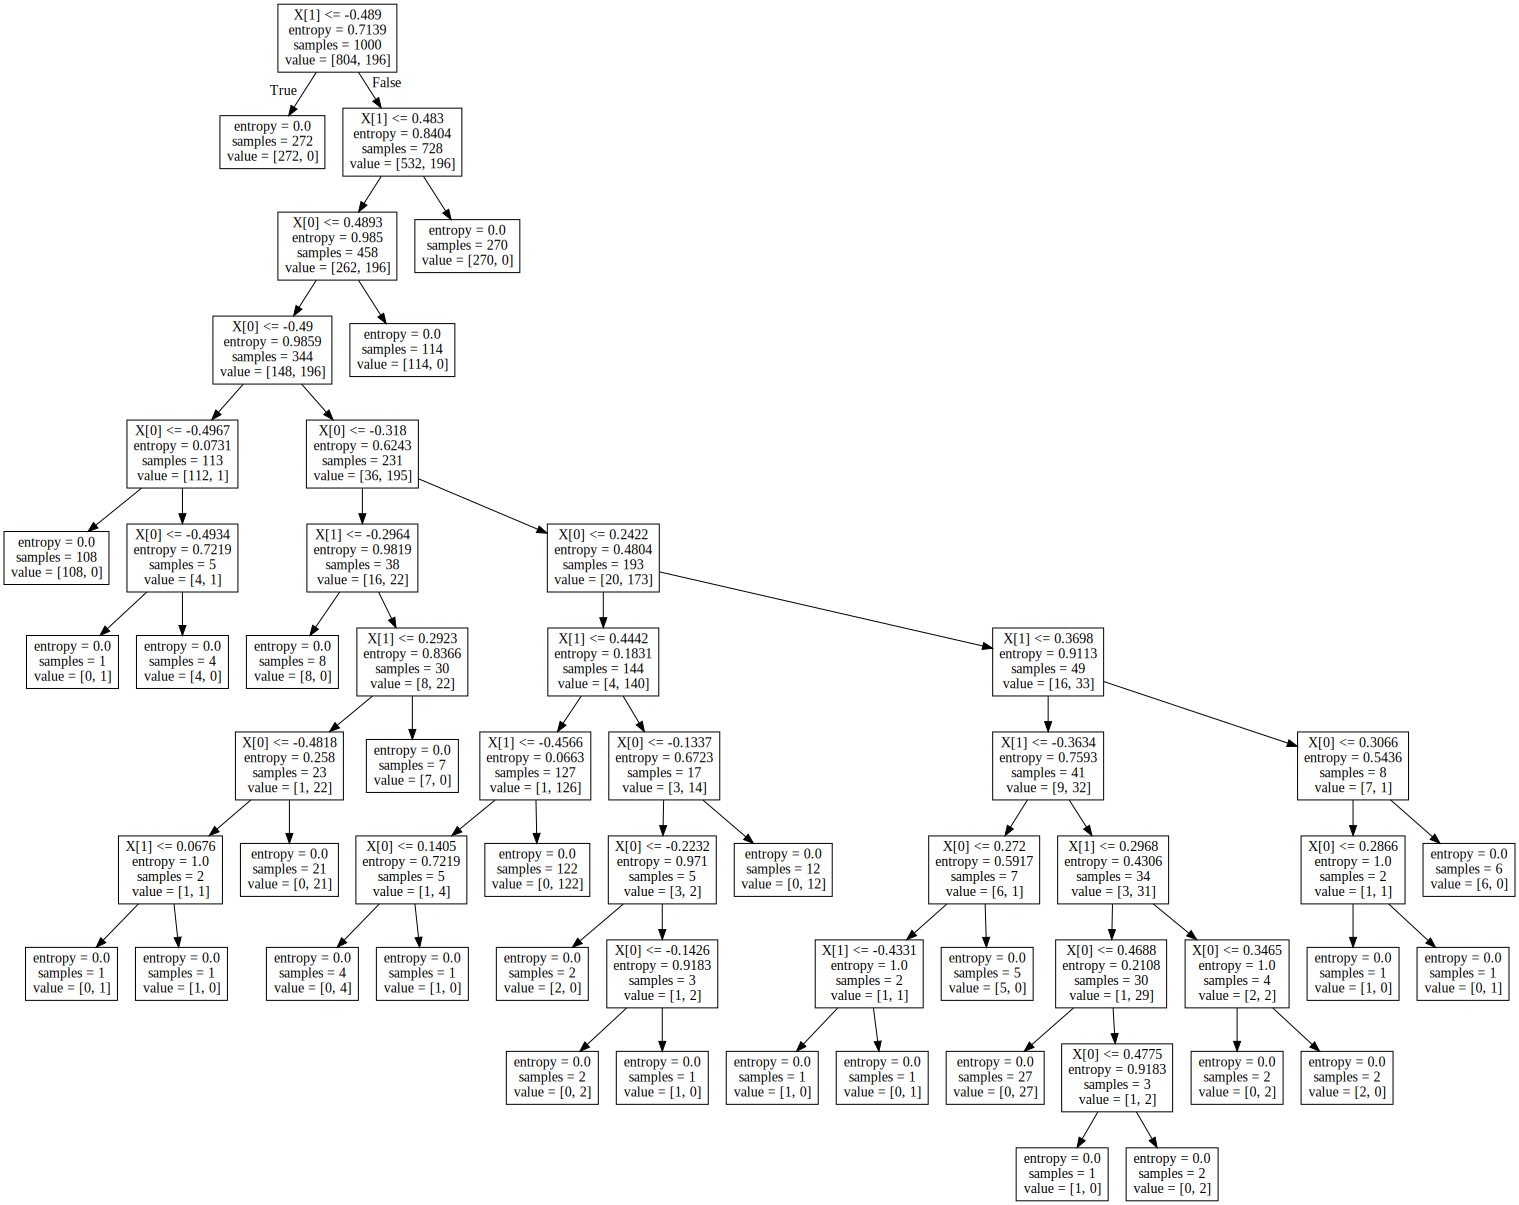

In [24]:
create_dotgraph(entropy_tree)

# Exploración de hiperparámetros

Busquemos la configuración de hiperparámetros del árbol que mejor se ajusta a nuestro conjunto

Primero, veamos los argumentos que recibe DecisionTreeClassifier

In [25]:
help(DecisionTreeClassifier)

Help on class DecisionTreeClassifier in module sklearn.tree.tree:

class DecisionTreeClassifier(BaseDecisionTree, sklearn.base.ClassifierMixin)
 |  A decision tree classifier.
 |  
 |  Read more in the :ref:`User Guide <tree>`.
 |  
 |  Parameters
 |  ----------
 |  criterion : string, optional (default="gini")
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "entropy" for the information gain.
 |  
 |  splitter : string, optional (default="best")
 |      The strategy used to choose the split at each node. Supported
 |      strategies are "best" to choose the best split and "random" to choose
 |      the best random split.
 |  
 |  max_features : int, float, string or None, optional (default=None)
 |      The number of features to consider when looking for the best split:
 |        - If int, then consider `max_features` features at each split.
 |        - If float, then `max_features` is a percentage and
 |         

In [26]:
from copy import copy

"""
Esto ya no lo usamos, mejor usar 
"""
def get_all_combinations(options):
    """
    Construye todas las combinaciones de las opciones
    """

    combinations = [{}]
    
    for option, values in options.iteritems():
        new_combinations = []
        
        for combination in combinations:
            """
            Para cada combinación previa tengo que generar una nueva seteando uno de
            los posibles valores de la opción
            """
            for value in values:
                new_combination = copy(combination)
                new_combination[option] = value
                new_combinations.append(new_combination)
        combinations = new_combinations
    return combinations

    

In [35]:
from sklearn.grid_search import GridSearchCV

options = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': range(2, 11), 
}

for scoring in ['accuracy', 'f1']:
    clf = DecisionTreeClassifier()
    print("=" * 80 + "\n")
    print("Scoring {}".format(scoring))
    
    grid_search = GridSearchCV(clf, scoring=scoring, param_grid=options, n_jobs=8)
    grid_search.fit(df[['X', 'Y']], df['spam'])

    #for value in grid_search.grid_scores_:
    #    print value
    
    for score in grid_search.grid_scores_:
        print score
    
    print "Mejor combinación: {}".format(grid_search.best_params_)
    print "Mejor valor: {}".format(grid_search.best_score_)


Scoring accuracy
mean: 0.80400, std: 0.00114, params: {'splitter': 'best', 'criterion': 'gini', 'max_depth': 2}
mean: 0.80400, std: 0.00114, params: {'splitter': 'random', 'criterion': 'gini', 'max_depth': 2}
mean: 0.83600, std: 0.01758, params: {'splitter': 'best', 'criterion': 'gini', 'max_depth': 3}
mean: 0.79600, std: 0.01243, params: {'splitter': 'random', 'criterion': 'gini', 'max_depth': 3}
mean: 0.94400, std: 0.00997, params: {'splitter': 'best', 'criterion': 'gini', 'max_depth': 4}
mean: 0.83800, std: 0.04268, params: {'splitter': 'random', 'criterion': 'gini', 'max_depth': 4}
mean: 0.94400, std: 0.00997, params: {'splitter': 'best', 'criterion': 'gini', 'max_depth': 5}
mean: 0.86300, std: 0.02954, params: {'splitter': 'random', 'criterion': 'gini', 'max_depth': 5}
mean: 0.95800, std: 0.00495, params: {'splitter': 'best', 'criterion': 'gini', 'max_depth': 6}
mean: 0.90800, std: 0.03086, params: {'splitter': 'random', 'criterion': 'gini', 'max_depth': 6}
mean: 0.97000, std: 0.

/home/marat/.pyenv/versions/2.7.11/envs/aprendizaje/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/marat/.pyenv/versions/2.7.11/envs/aprendizaje/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/marat/.pyenv/versions/2.7.11/envs/aprendizaje/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/marat/.pyenv/versions/2.7.11/envs/aprendizaje/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted 

mean: 0.00000, std: 0.00000, params: {'splitter': 'best', 'criterion': 'gini', 'max_depth': 2}
mean: 0.00000, std: 0.00000, params: {'splitter': 'random', 'criterion': 'gini', 'max_depth': 2}
mean: 0.70023, std: 0.02469, params: {'splitter': 'best', 'criterion': 'gini', 'max_depth': 3}
mean: 0.13784, std: 0.19455, params: {'splitter': 'random', 'criterion': 'gini', 'max_depth': 3}
mean: 0.86150, std: 0.02408, params: {'splitter': 'best', 'criterion': 'gini', 'max_depth': 4}
mean: 0.44032, std: 0.32178, params: {'splitter': 'random', 'criterion': 'gini', 'max_depth': 4}
mean: 0.86043, std: 0.02256, params: {'splitter': 'best', 'criterion': 'gini', 'max_depth': 5}
mean: 0.61847, std: 0.14952, params: {'splitter': 'random', 'criterion': 'gini', 'max_depth': 5}
mean: 0.89660, std: 0.01532, params: {'splitter': 'best', 'criterion': 'gini', 'max_depth': 6}
mean: 0.69057, std: 0.10452, params: {'splitter': 'random', 'criterion': 'gini', 'max_depth': 6}
mean: 0.92525, std: 0.00746, params: {'s

In [ ]:
# Ejempl